In [18]:
# Loading datasets

import torch
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=25,
                                           shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=4)

print(trainset.data.size())
print("Done importing data.")

torch.Size([60000, 28, 28])
Done importing data.


In [19]:
# Defining the models
import torch.nn as nn
import torch.nn.functional as F

# Convolutional Neural Network (CNN)
class ConvNet(nn.Module):
    def __init__(self, dropout_coef, batch_norm):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 120)
        self.fc2_bn = nn.BatchNorm1d(120)
        self.fc3 = nn.Linear(120, 10)
        self.dropout = nn.Dropout(dropout_coef)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x)) if self.batch_norm else self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)

        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)) if self.batch_norm else self.fc1(x))

        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc2_bn(self.fc2(x)) if self.batch_norm else self.fc2(x))

        # Apply dropout
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, dropout_coef, batch_norm):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc2_bn = nn.BatchNorm1d(120)
        self.fc3 = nn.Linear(120, 120)
        self.fc3_bn = nn.BatchNorm1d(120)
        self.fc4 = nn.Linear(120, 10)
        self.dropout = nn.Dropout(dropout_coef)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = x.view(-1, 28 * 28 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2_bn(self.fc2(x)) if self.batch_norm else self.fc2(x))

        # Apply dropout
        x = self.dropout(x)
        x = F.relu(self.fc3_bn(self.fc3(x)) if self.batch_norm else self.fc3(x))

        # Apply dropout
        x = self.dropout(x)
        x = self.fc4(x)

        return x

class SoftmaxRegression(nn.Module):
    def __init__(self, dropout_coef, batch_norm):
        super(SoftmaxRegression, self).__init__()
        self.input_bn = nn.BatchNorm1d(28 * 28 *1)
        self.fc1 = nn.Linear(28 * 28 * 1, 10)
        self.dropout = nn.Dropout(dropout_coef)
        self.softmax = nn.Softmax(dim=1)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = x.view(-1, 28 * 28 * 1)

        # Apply dropout
        x = self.dropout(x)
        x = self.input_bn(x) if self.batch_norm else x
        x = self.softmax(self.fc1(x))

        return x

In [20]:
# Moving the nets to a GPU
netDict={"CNN": ConvNet(dropout_coef=0, batch_norm=False),
         "CNN_Dropout": ConvNet(dropout_coef=0.5, batch_norm=False),
         "CNN_BatchNorm": ConvNet(dropout_coef=0, batch_norm=True),
         "MLP": MLP(dropout_coef=0, batch_norm=False),
         "MLP_Dropout": MLP(dropout_coef=0.5, batch_norm=False),
         "MLP_BatchNorm": MLP(dropout_coef=0, batch_norm=True),
         "Softmax": SoftmaxRegression(dropout_coef=0, batch_norm=False),
         "Softmax_Dropout": SoftmaxRegression(dropout_coef=0.5, batch_norm=False),
         "Softmax_BatchNorm": SoftmaxRegression(dropout_coef=0, batch_norm=True)}

CUDA = torch.cuda.is_available()
if CUDA:
  for net in netDict.values():
    net.cuda()

# Let's first define our device as the first visible cuda device if we have
# CUDA available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1650


In [21]:
import torch.optim as optim
# Train and test the networks
accuracy_per_model = dict()
loss_per_model = dict()

for key, net in netDict.items():
  print(net)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  accuracy_values=[]
  loss_values=[]
  epoch_number=[]
  for epoch in range(25):  # loop over the dataset multiple times. Here 10 means 10 epochs
      running_loss = 0.0
      for i, (inputs,labels) in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
          else:
            inputs = inputs.cpu()
            labels = labels.cpu()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[epoch%d, itr%5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

      correct = 0
      total = 0
      running_test_loss = 0.0
      with torch.no_grad():
          for images, labels in test_loader:
              if CUDA:
                images = images.cuda()
                labels = labels.cuda()
              else:
                images = images.cpu()
                labels =labels.cpu()

              outputs = net(images)
              running_test_loss += criterion(outputs, labels).item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              if CUDA:
                correct += (predicted.cpu()==labels.cpu()).sum().item()
              else:
                correct += (predicted==labels).sum().item()
          TestAccuracy = 100 * correct / total
          TestLoss = running_test_loss / total
          epoch_number += [epoch+1]
          accuracy_values += [TestAccuracy]
          loss_values += [TestLoss]
          print('Epoch=%d Test Accuracy=%.3f' %
                    (epoch + 1, TestAccuracy))

  print('Finished Training')
  accuracy_per_model[key] = accuracy_values
  loss_per_model[key] = loss_values


ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (fc2_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
[epoch1, itr 2000] loss: 0.592
Epoch=1 Test Accuracy=96.830
[epoch2, itr 2000] loss: 0.096
Epoch=2 Test Accuracy=97.760
[epoch3, itr 2000] loss: 0.067
Epoch=3 Test Accuracy=98.290
[epoch4, itr 2000] loss: 0.052
Epoch=4 Test Accuracy=98.670
[epo

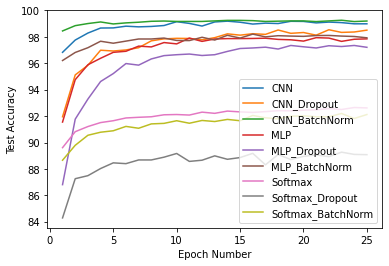

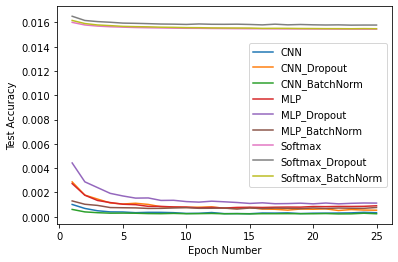

In [25]:
import matplotlib.pyplot as plt

'''
################## Plotting the Test Accuracy ##################
'''
# Plot the data
for key, value in accuracy_per_model.items():
    plt.plot(epoch_number, value, label=key)

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy")

# Show the plot
plt.show()

'''
################## Plotting the Test Loss ##################
'''
# Plot the data
for key, value in loss_per_model.items():
    plt.plot(epoch_number, value, label=key)

# Add a legend
plt.legend()

# Add labels
plt.xlabel("Epoch Number")
plt.ylabel("Test Accuracy")

# Show the plot
plt.show()